<a href="https://colab.research.google.com/github/AdamClarkStandke/GenerativeDeepLearning/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Dimensional Latent Space VAE


---



# Loading Celeb Faces, Preprocess and imports

In [1]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download jessicali9530/celeba-dataset
!unzip -d dataset celeba-dataset.zip

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    losses,
    optimizers
)

from scipy.stats import norm
import pandas as pd
import tensorflow_datasets as tfds

In [4]:
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 64
Z_DIM = 200 # latent space is 200 dimensional
LEARNING_RATE = 0.0005
EPOCHS = 10
BETA = 2000 # weighting value applied to reconstruction loss
LOAD_MODEL = False

In [5]:
def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

In [ ]:
train_data = utils.image_dataset_from_directory(
    "dataset/img_align_celeba/img_align_celeba",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

In [7]:
# Preprocess the data
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img


train = train_data.map(lambda x: preprocess(x))

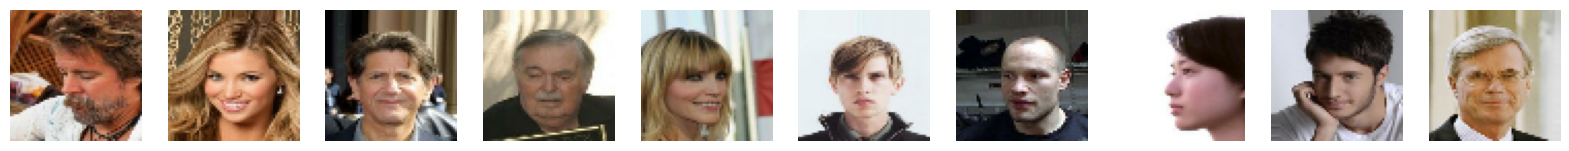

In [20]:
train_sample = sample_batch(train)
display(train_sample, cmap=None)

# Really Important: Creating the Sampling Layer

This is the Sampling Layer used in the Encoder network to sample the point *z* from the latent space as defined by *z_mean* and *z_log_var* through the use of the ["repramaterization trick"](https://arxiv.org/abs/1312.6114). Namely, we actually sample the point *epsilon* from a standard normal distribution and modify *epsilon* through the use of *z_mean* and *z_log_var* that come from a dense layer. Doing so allows for the gradients to be computed for *z_mean* and *z_log_var* and backpropagated. Otherwise the backpropagation algorithm could not be used. The repramaterization equation is the following:

\begin{align} z = z_{mean} + z_{sigma} * epsilon \\z_{mean} = exp(z_{logvar} * 0.5) \\epsilon= N(0, I)\end{align}

In [8]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim)) # sampling from a standard normal distribution
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon # the repramaterization trick!

# Creating the Encoder

In [9]:
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(
    encoder_input
)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
z_mean = layers.Dense(Z_DIM, name="z_mean")(x)
z_log_var = layers.Dense(Z_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           1792      ['encoder_input[0][0]']       
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)           0         ['batch_normalization[0]

# Creating the Decoder

In [10]:
# Decoder
decoder_input = layers.Input(shape=(Z_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
decoder_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=3, strides=1, activation="sigmoid", padding="same"
)(x)
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 256)               51456     
                                                                 
 batch_normalization_5 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 256)               0         
                                                                 
 reshape (Reshape)           (None, 2, 2, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 64)          36928     
 anspose)                                                    

# Creating the Variational AutoEncoder

In [11]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    # Function that calls the encoder-decoder network
    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs) # input passed to encoder to output z sample
        reconstruction = decoder(z) # z sample passed to decoder to reconstruct input
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        # Forward propagation portion
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data, training=True)
            # Calculation of reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                BETA * losses.mean_squared_error(data, reconstruction)
            )
            # Calculation of kl loss
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            # Calculation of total loss
            total_loss = reconstruction_loss + kl_loss

        # Backpropagation portion
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Metric update portion
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA * losses.mean_squared_error(data, reconstruction)
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

# Training the Variational Autoencoder

In [ ]:
vae = VAE(encoder, decoder)
# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
vae.compile(optimizer=optimizer)
# start
vae.fit(
    train,
    epochs=EPOCHS,
)
# Save the final models
vae.save("./drive/MyDrive/models/vae")
encoder.save("./drive/MyDrive/models/encoder")
decoder.save("./drive/MyDrive/models/decoder")

# Generating non-novel images

In [12]:
 vae = VAE(encoder, decoder)
 vae.load_weights("./drive/MyDrive/models/vae")
 encoder.load_weights("./drive/MyDrive/models/encoder")
 decoder.load_weights("./drive/MyDrive/models/decoder")

In [ ]:
# Select a subset of the test set
batches_to_predict = 1
example_images = np.array(
    list(train.take(batches_to_predict).get_single_element())
)

4/4 [==============================] - 1s 82ms/step
Example real faces


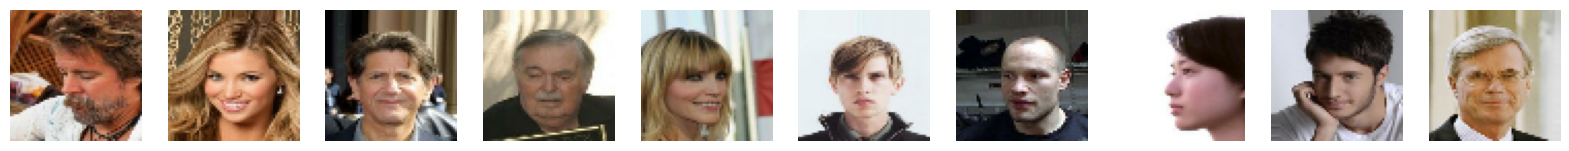

Reconstructions


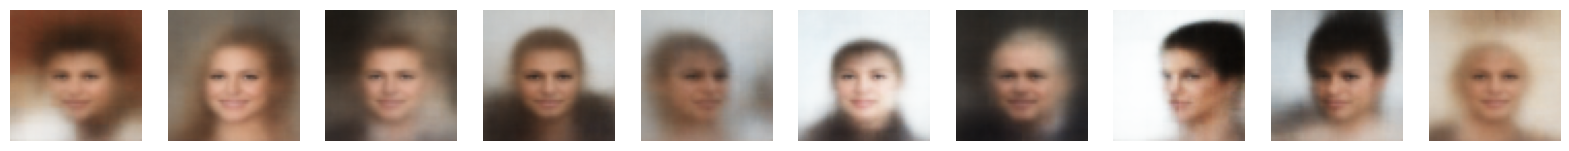

In [ ]:
# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real faces")
display(example_images)
print("Reconstructions")
display(reconstructions)

# Visualizing and Analyzing the Latent Space

To visualize the latent space we take the previous sample images from the previous section (i.e., images used to generate non-novel/reconstruction images) and input the 128 images into the encoder of the Variational Autoencoder. This outputs the sample matrix z representing the 128 images in 200 dimensional space.  

In [ ]:
_, _, z = vae.encoder.predict(example_images)

4/4 [==============================] - 0s 13ms/step


Each instance of the 128 instances is a vector of 200 values (i.e., 200 dimensional)

In [ ]:
z.shape

(128, 200)

As can be seen from the kernal density estimation each instance's latent space vector (i.e., the 200 values/dimensions) is basically centered at zero with a variance of positive/negative 2

<Axes: ylabel='Density'>

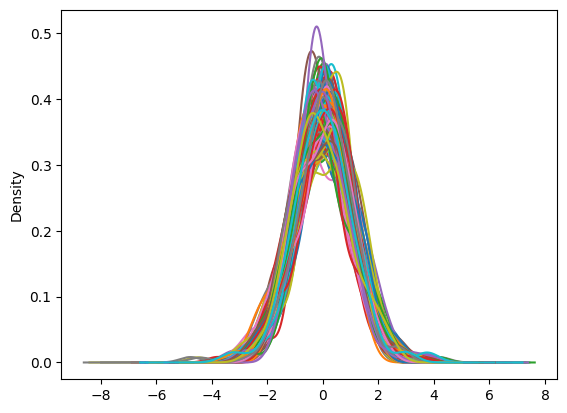

In [ ]:
x=pd.DataFrame(z[:, :])
x.plot(kind='kde', legend=False)

As seen from the histograms and density curves each of the 200 dimensions for each of the 128 sample points of the latent space are basically normally distributed but some dimensions are more normally distributed (i.e., standard normal) versus others, indicating the BETA weight value should probably be decreased allowing the loss function to focus more attention on kl loss.

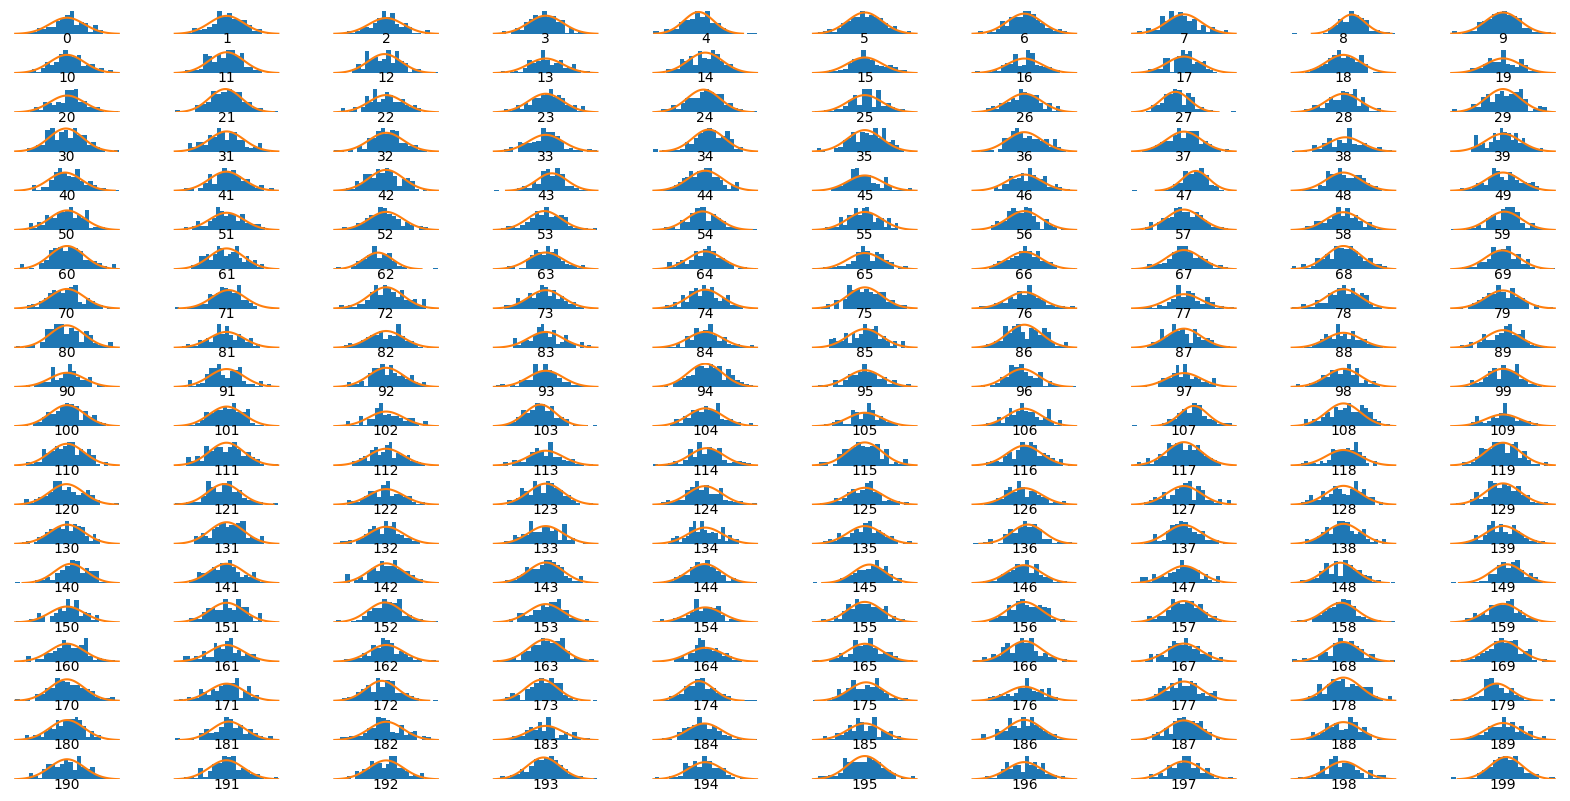

In [ ]:
x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(200):
    ax = fig.add_subplot(20, 10, i + 1)
    ax.hist(z[:, i], density=True, bins=20)
    ax.axis("off")
    ax.text(
        0.5, -0.35, str(i), fontsize=10, ha="center", transform=ax.transAxes
    )
    ax.plot(x, norm.pdf(x))

plt.show()

# Generating novel images using the decoder

These novel images are generated from a standard normal distribution (i.e., the z_sample) and DO NOT COME FROM THE INPUT IMAGES!!! The decoder will transform a standard random normal distribution into an image (in this case a human face, due to the weights of the VAE).

1/1 [==============================] - 1s 608ms/step


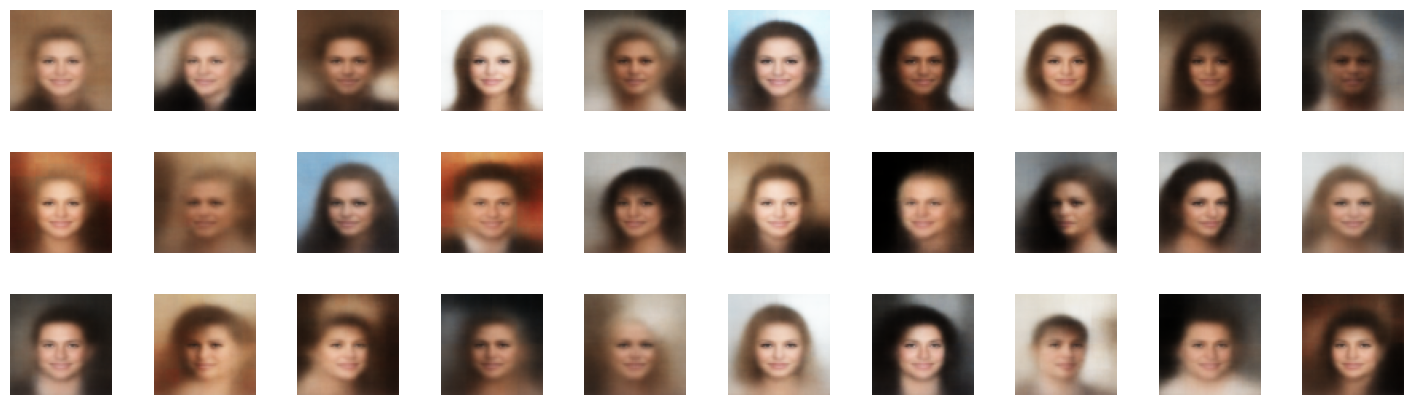

In [ ]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))
# Decode the sampled points
reconstructions = decoder.predict(z_sample)
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :])

# Latent Space Arithmetic

Because the Latent Space encodes the main image features in a 200 dimensional space rather than a 4096 dimensional space as represented by a vector of 200 values (i.e., an embedding) one can perform linear algebra operations on the feature vector associated with the labeled attribute before inputting the transformed feature vector along with the orginal latent space vector (i.e. z) back into the decoder to produce the image (which in this example are faces).

This is done by grouping the image features with the labeled attribute (for example, images labeled with sunglasses) into clusters. In this case, this dataset is the [CelebFaces Attributes (CelebA) Dataset](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset?select=list_attr_celeba.csv) which has 40 labels attached to each image represented as either a -1 or 1. The label I will be playing with is the "attractive" label. Once the feature vector associated with the label is found it will be scaled; namely, the more positive this vector becomes the more/less "attractive" the face produced by the decoder becomes and vice versa.  The following code snippet as written by [David Foster](https://www.amazon.com/Generative-Deep-Learning-Teaching-Machines/dp/1492041947) details this method.

The two functions that do the heavy lifting are get_vector_from_label and add_vector_to_images.

*   **get_vector_from_label**

> The function takes in not only the images as before but also the label associated with the image. This is stored in the variable *data*. In addition we pass in the trained variational autoencoder, number of dimensions of the latent space and the label assoicated with the image we are searching for in the latent space. Currently the number of search iterations in the latent space is set to 10,000 but the search will stop if the movement of the mean positive/negative position vector is less than 0.08. Either way the feature vector associated with the label we want will be returned.     

*   **add_vector_to_images**

> Once we have the feature vector associated with the label we want (i.e. attractiveness) is extracted from the latent space we scale it by different positive/negative values to make the feature more pronounced or less pronounced (i.e. really attractive or really ugly). And add the scaled feature vector with the label we want to the original latent space vector (i.e. z) and feed it to the decoder.  


In [13]:
# Load the label dataset
attributes = pd.read_csv("dataset/list_attr_celeba.csv")

In [14]:
# Load the face data with the associated labels
LABEL = "Attractive"  # associated label we want to extract from the latent space
train_data = utils.image_dataset_from_directory(
    "dataset/img_align_celeba/img_align_celeba",
    labels=attributes[LABEL].tolist(),
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 202599 files belonging to 2 classes.


In [15]:
# Preprocess the data
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img


labelled = train_data.map(lambda x, y: (preprocess(x), y))

In [16]:
def get_vector_from_label(data, vae, embedding_dim, label):
    current_sum_POS = np.zeros(shape=embedding_dim, dtype="float32")
    current_n_POS = 0
    current_mean_POS = np.zeros(shape=embedding_dim, dtype="float32")

    current_sum_NEG = np.zeros(shape=embedding_dim, dtype="float32")
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape=embedding_dim, dtype="float32")

    current_vector = np.zeros(shape=embedding_dim, dtype="float32")
    current_dist = 0

    print("label: " + label)
    print("images : POS move : NEG move :distance : 𝛥 distance")
    while current_n_POS < 10000:
        batch = list(data.take(1).get_single_element())
        im = batch[0]
        attribute = batch[1]

        _, _, z = vae.encoder.predict(np.array(im), verbose=0)

        # filtering instances with the associated label
        z_POS = z[attribute == 1]
        z_NEG = z[attribute == -1]

        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis=0) # position of the positive vector
            current_n_POS += len(z_POS) # number of positive instances
            new_mean_POS = current_sum_POS / current_n_POS # position of the mean positive vector
            movement_POS = np.linalg.norm(new_mean_POS - current_mean_POS) # calculating change of mean positive vector (i.e. 𝛥 distance)

        if len(z_NEG) > 0:
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis=0) # position of the negative vector
            current_n_NEG += len(z_NEG) # number of negative instances
            new_mean_NEG = current_sum_NEG / current_n_NEG # position of the mean negative vector
            movement_NEG = np.linalg.norm(new_mean_NEG - current_mean_NEG) # calculating change of mean negative vector (i.e. 𝛥 distance)

        current_vector = new_mean_POS - new_mean_NEG # vec subtract to obtain position of vector with assoicated label (i.e.vector we want)
        new_dist = np.linalg.norm(current_vector) # calculating the magnitude of vector with associated label(i.e. vector we want)
        dist_change = new_dist - current_dist # calculating the distance change of vector associated with label (i.e. vector we want)

        print(
            "# of positive search iterations:"+str(current_n_POS)
            + "|"
            "𝛥 mean positive vector:"+ str(np.round(movement_POS, 3))
            + "|"
            "𝛥  mean negative vector:"+ str(np.round(movement_NEG, 3))
            + "|"
            "magnitude of vector we want:"+ str(np.round(new_dist, 3))
            + "|"
            "𝛥 of vector we want:"+ str(np.round(dist_change, 3))
        )

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        # threshold to terminate search for vector with associated label (i.e. vector we want)
        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            print("Found the " + label + " vector")
            break

    return current_vector


def add_vector_to_images(data, vae, feature_vec):
    n_to_show = 5
    # how much to scale the feature we want (positive=more, negative=less, zero=neutral)
    factors = [-4, -3, -2, -1, 0, 1, 2, 3, 4]

    example_batch = list(data.take(1).get_single_element())
    example_images = example_batch[0]

    _, _, z_points = vae.encoder.predict(example_images, verbose=0)

    fig = plt.figure(figsize=(18, 10))

    counter = 1

    for i in range(n_to_show):
        img = example_images[i]
        sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
        sub.axis("off")
        sub.imshow(img)

        counter += 1

        for factor in factors:
            # scaling the vector we want (i.e. feature_vec) by factors and adding it to orginal latent space vector
            changed_z_point = z_points[i] + feature_vec * factor
            # the changed image with the associated label
            changed_image = vae.decoder.predict(
                np.array([changed_z_point]), verbose=0
            )[0]

            sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
            sub.axis("off")
            sub.imshow(changed_image)

            counter += 1

    plt.show()

*   morph_faces


> Another thing you can do in the latent space is **"morph things"**, such as faces for example. Given two points in the latent space representing two different facial images one can take the latent vector of point A and transform it into a latent vector representing point B with simple vector addition and scaling. The vector equation to do this is the following:


> \begin{align} z_{new} = z_{A} * (1- alpha) + zᵦ * alpha \end{align} where zₐ is the latent vector representing face A, zᵦ is the latent vector representing face B, alpha is a scaler from 0 to 1 and z_new is the latent vector representing the morphed face (i.e. a combination of face A with face b when alpha does not equal 1 or 0)

In [17]:
def morph_faces(data, vae):
    factors = np.arange(0, 1, 0.1)

    example_batch = list(data.take(1).get_single_element())[:2]
    example_images = example_batch[0]
    _, _, z_points = vae.encoder.predict(example_images, verbose=0)

    fig = plt.figure(figsize=(18, 8))

    counter = 1

    img = example_images[0]
    sub = fig.add_subplot(1, len(factors) + 2, counter)
    sub.axis("off")
    sub.imshow(img)

    counter += 1

    for factor in factors:
        changed_z_point = z_points[0] * (1 - factor) + z_points[1] * factor
        changed_image = vae.decoder.predict(
            np.array([changed_z_point]), verbose=0
        )[0]
        sub = fig.add_subplot(1, len(factors) + 2, counter)
        sub.axis("off")
        sub.imshow(changed_image)

        counter += 1

    img = example_images[1]
    sub = fig.add_subplot(1, len(factors) + 2, counter)
    sub.axis("off")
    sub.imshow(img)

    plt.show()

label: Attractive
images : POS move : NEG move :distance : 𝛥 distance
# of positive search iterations:65|𝛥 mean positive vector:1.742|𝛥  mean negative vector:1.919|magnitude of vector we want:2.712|𝛥 of vector we want:2.712
# of positive search iterations:133|𝛥 mean positive vector:1.169|𝛥  mean negative vector:1.26|magnitude of vector we want:1.921|𝛥 of vector we want:-0.79
# of positive search iterations:192|𝛥 mean positive vector:0.688|𝛥  mean negative vector:0.717|magnitude of vector we want:1.658|𝛥 of vector we want:-0.264
# of positive search iterations:249|𝛥 mean positive vector:0.481|𝛥  mean negative vector:0.524|magnitude of vector we want:1.499|𝛥 of vector we want:-0.159
# of positive search iterations:313|𝛥 mean positive vector:0.425|𝛥  mean negative vector:0.373|magnitude of vector we want:1.427|𝛥 of vector we want:-0.072
# of positive search iterations:380|𝛥 mean positive vector:0.317|𝛥  mean negative vector:0.315|magnitude of vector we want:1.29|𝛥 of vector we want:-0.137

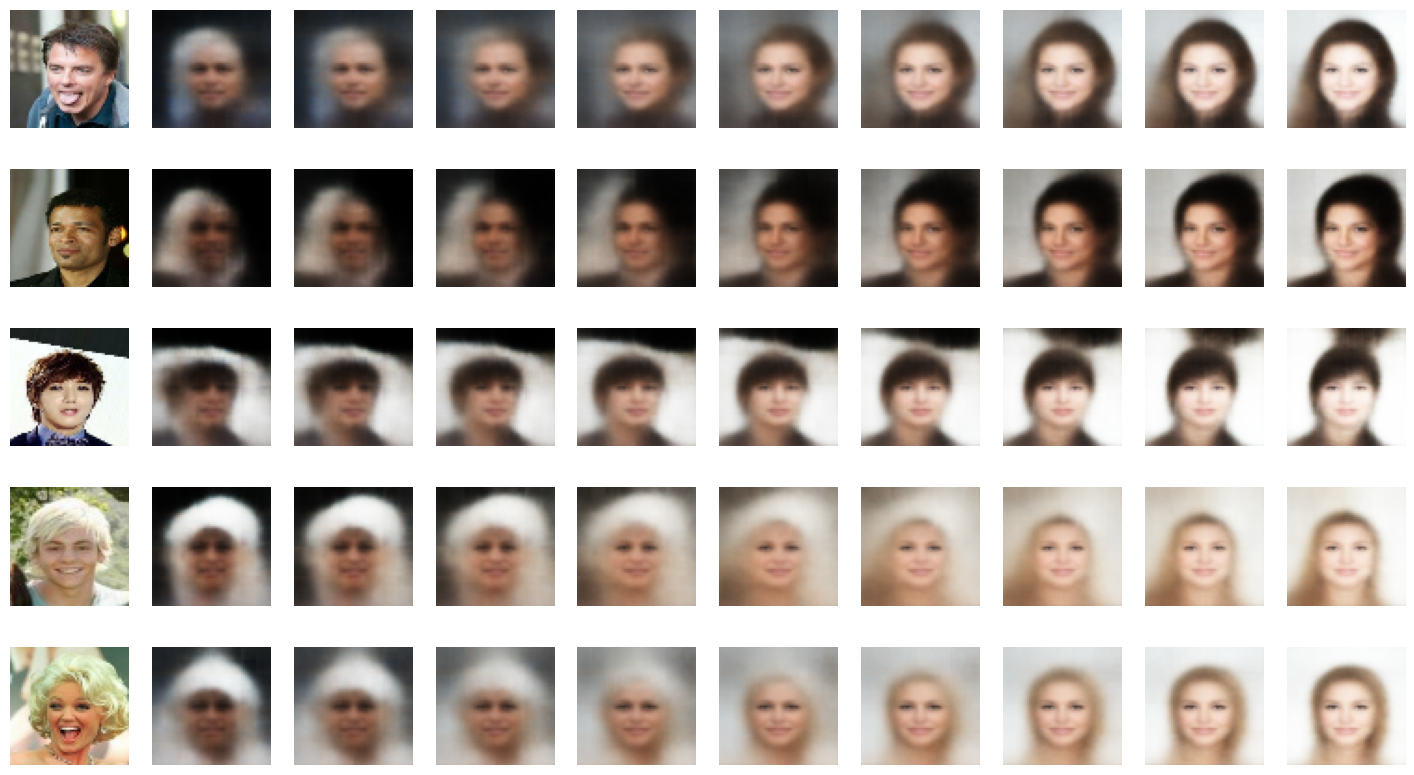

In [18]:
# Find the feature vector with associated label
attribute_vec = get_vector_from_label(labelled, vae, Z_DIM, LABEL)
# Add feature vector with associated label to images
add_vector_to_images(labelled, vae, attribute_vec)

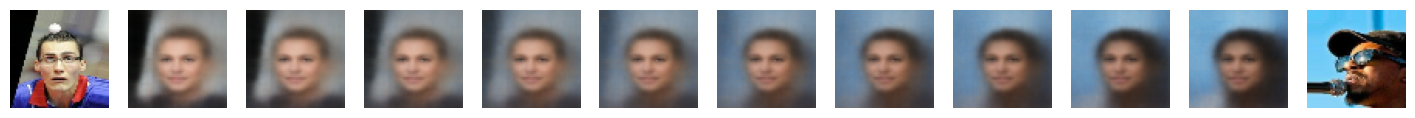

In [19]:
# Morphing Latent Vectors
morph_faces(labelled, vae)